Varroa Mite Detection 1.22 Brightness and Blur

In [1]:
# Cell Block 1: Importing Libraries
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold, train_test_split
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [2]:
# Cell Block 2: Load Data and Preprocess

df = pd.read_csv('labels_augmented.csv')

df['filename'] = df['filename'].apply(lambda fn: os.path.join('rotations_flips', fn.strip()))

filepaths = df['filename'].values
labels = df['has_mite'].values

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.51273596..1.4578522].


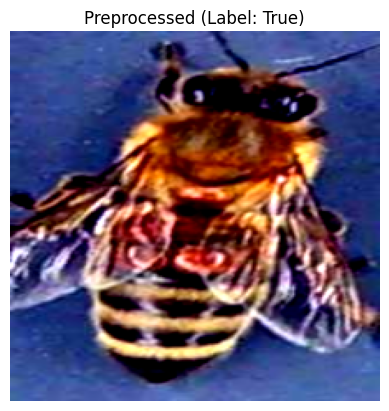

In [42]:

# Guassian kernel function
def gaussian_kernel(size: int, sigma: float):
    x = tf.range(-size // 2 + 1, size // 2 + 1, dtype=tf.float32)
    xx, yy = tf.meshgrid(x, x)
    kernel = tf.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    kernel = kernel / tf.reduce_sum(kernel)
    return kernel

def apply_gaussian_blur(image, kernel_size=5, sigma=1.0):
    kernel = gaussian_kernel(kernel_size, sigma)                 # [5, 5]
    kernel = kernel[:, :, tf.newaxis, tf.newaxis]                # [5, 5, 1, 1]
    kernel = tf.repeat(kernel, repeats=3, axis=2)                # [5, 5, 3, 1] ✅ CORRECT shape
    image = tf.expand_dims(image, 0)                             # [1, H, W, 3]
    blurred = tf.nn.depthwise_conv2d(image, kernel, strides=[1,1,1,1], padding='SAME')
    
    return tf.squeeze(blurred, axis=0)

# ===== Load and Preprocess One Image =====
def preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = img / 255.0

    # # 1) Apply Gaussian blur
    # img = apply_gaussian_blur(img, kernel_size=5, sigma=1.0)

    # 2) Boost blue channel
    img = tf.clip_by_value(img + [0.0, 0.0, 0.2], 0.0, 1.0) 

    # 3) Increase contrast
    img = tf.image.adjust_contrast(img, 2.0) 

    # # 4) Boost red channel
    # img = tf.clip_by_value(img + [0.2, 0.0, 0.0], 0.0, 1.0)

    # # 5) Boost blue and red channel
    # img = tf.clip_by_value(img + [0.2, 0.0, 0.2], 0.0, 1.0)

    # 6) Boost the Brightness
    img = tf.image.adjust_brightness(img, delta=-0.1)


    return img

# ===== Main =====
if __name__ == "__main__":
    # Load CSV
    df = pd.read_csv("labels_augmented.csv")
    df['filename'] = df['filename'].apply(lambda fn: os.path.join("rotations_flips", fn.strip()))

    # Pick one image to preview
    sample_path = df['filename'].iloc[0]       # <- change index to preview different rows
    label = df['has_mite'].iloc[0]

    # Load and preprocess
    pre_img = preprocess_image(sample_path)

    # Show image
    plt.imshow(pre_img.numpy())
    plt.title(f"Preprocessed (Label: {label})")
    plt.axis("off")
    
    plt.show()